# CelebA Automatic Portrait Segmentation

***

# Overview

### Dataset description

The [CelebA dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html), described in the paper [Deep Learning Face Attributes in the Wild](https://arxiv.org/pdf/1411.7766.pdf), is a publicly available dataset consisting of 202,599 face images of various celebrities, in various poses and different backgrounds. Images are divided into train/validation/test set as follows:

* Images from 000001 to 162770: training

* Images from 162771 to 182637: validation

* Images from 182638 to 202599: testing

This dataset was created for various computer vision tasks such as face attribute recognition, face detection, and landmark localization; indeed in addition to the images, the dataset comes equipped with various csv files containing information about:

* Presence or absence of 40 different attributes for each image, such as "bald", "big nose", "black hair";

* Coordinates of five different image landmarks (left eye, right eye, nose, left mouth, right mouth);

* Coordinates of face bounding box.

For this exercise we will use a [Kaggle version](https://www.kaggle.com/jessicali9530/celeba-dataset) of this dataset, in which all images are cropped to size 178 x 218 (width x height).

### Exercise requirements

The [exercise](https://fellowship.ai/challenge) goal is to develop an automatic portrait segmentation model and apply it on the CelebA dataset. No particular metric requirements were specified: this is because the CelebA dataset does not come with ground truth segmentations, which makes it impossible to numerically evaluate our model. We will therefore only give a qualitative evaluation, by displaying the model's output segmentation for a random subset of CelebA images.

### Approach

To solve this problem we first look for datasets more appropriate for portrait segmentation, which should contain both portrait images and their ground truth segmentations. The only good, publicly available dataset of this type we were able to find is the one described in the paper [Deep Automatic Portrait Matting](http://xiaoyongshen.me/papers/deepmatting.pdf), which can be downloaded from http://xiaoyongshen.me/webpages/webpage_automatting/: this contains 2000 portraits (1700 training + 300 validation) 
and their ground truth alpha matte, from which we can obtain the ground truth segmentations. We then use this portraits dataset to train a **U-net** model, which is usually quite efficient for segmentation tasks. Finally, we apply our U-net to a random subset of images in the CelebA dataset and discuss the segmentation results. For this exercise we will mainly use the [fastai](https://www.fast.ai/) library based on [PyTorch](https://pytorch.org/).
 

### Previous results

We are not aware of any previous results for this problem.

### Technical specifications

This notebook has been created on the Kaggle platform, which provides both free GPU access and the CelebA [dataset](https://www.kaggle.com/jessicali9530/celeba-dataset).

***

# Data analysis and visualization

First of all, let us import some useful libraries:

In [1]:
import numpy as np  
import pandas as pd  

%matplotlib inline
import matplotlib as mpl
mpl.rcParams.update({'figure.max_open_warning': 0})    # To avoid warnings when showing more than 20 images
import matplotlib.pyplot as plt
import sys
import re
from time import time
import glob
import PIL

from fastai import *
from fastai.vision import *

import os

In the input directory we have two dataset: one is [CelebA](https://www.kaggle.com/jessicali9530/celeba-dataset), the other is a [portrait segmentation dataset](http://xiaoyongshen.me/webpages/webpage_automatting/) which we will use to train our model

In [2]:
print(os.listdir("../input"))

['segmentation', 'celeba-dataset']


Let us therefore look at these two datasets separately.

### CelebA dataset

The 'celeba-dataset' folder contains four csv files and one image folder:

In [3]:
path_celeb = Path("/kaggle/input/celeba-dataset")
path_celeb.ls()

[PosixPath('/kaggle/input/celeba-dataset/img_align_celeba'),
 PosixPath('/kaggle/input/celeba-dataset/list_eval_partition.csv'),
 PosixPath('/kaggle/input/celeba-dataset/list_attr_celeba.csv'),
 PosixPath('/kaggle/input/celeba-dataset/list_landmarks_align_celeba.csv'),
 PosixPath('/kaggle/input/celeba-dataset/list_bbox_celeba.csv')]

The 'list_landmarks_align_celeba' csv file contains the coordinates of five image landmarks (left eye, right eye, nose, left mouth, right mouth):

In [4]:
pd.read_csv(path_celeb/'list_landmarks_align_celeba.csv').head()

image_id  lefteye_x      ...       rightmouth_x  rightmouth_y
0  000001.jpg         69      ...                108           154
1  000002.jpg         69      ...                108           153
2  000003.jpg         76      ...                 98           158
3  000004.jpg         72      ...                101           151
4  000005.jpg         66      ...                104           150

[5 rows x 11 columns]

The 'list_attr_celeba' csv file contains information about the presence (1) or absence (-1) of 40 different attributes:

In [5]:
pd.read_csv(path_celeb/'list_attr_celeba.csv').head()

image_id  5_o_Clock_Shadow  ...    Wearing_Necktie  Young
0  000001.jpg                -1  ...                 -1      1
1  000002.jpg                -1  ...                 -1      1
2  000003.jpg                -1  ...                 -1      1
3  000004.jpg                -1  ...                 -1      1
4  000005.jpg                -1  ...                 -1      1

[5 rows x 41 columns]

The 'list_eval_partition' csv file tells us the train (0) / validation (1) / test (2) splitting:

In [6]:
# 000001-162770: training
# 162771-182637: validation
# 182638-202599: testing

pd.read_csv(path_celeb/'list_eval_partition.csv').loc[[0, 162770, 182637]]

image_id  partition
0       000001.jpg          0
162770  162771.jpg          1
182637  182638.jpg          2

The 'list_bbox_celeba' csv file instead provides upper left point coordinate, width and heigth of face bounding boxes:

In [7]:
pd.read_csv(path_celeb/'list_bbox_celeba.csv').head()

image_id  x_1  y_1  width  height
0  000001.jpg   95   71    226     313
1  000002.jpg   72   94    221     306
2  000003.jpg  216   59     91     126
3  000004.jpg  622  257    564     781
4  000005.jpg  236  109    120     166

Finally, the 'img_align_celeba' folder contains a folder with the whole set of 202599 images. Looking at the file names, we can see that thay are labeled by an integer from 1 to 202599: for example, the first five images are

In [8]:
sorted((path_celeb/'img_align_celeba/img_align_celeba').ls())[:5]

[PosixPath('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/000001.jpg'),
 PosixPath('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/000002.jpg'),
 PosixPath('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/000003.jpg'),
 PosixPath('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/000004.jpg'),
 PosixPath('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/000005.jpg')]

while the last five images are

In [9]:
sorted((path_celeb/'img_align_celeba/img_align_celeba').ls())[-5:]

[PosixPath('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/202595.jpg'),
 PosixPath('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/202596.jpg'),
 PosixPath('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/202597.jpg'),
 PosixPath('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/202598.jpg'),
 PosixPath('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/202599.jpg')]

In [10]:
print('Total number of images in Celeba dataset:', len((path_celeb/'img_align_celeba/img_align_celeba').ls()))

Total number of images in Celeba dataset: 202599


Clearly for the purposes of our exercise the information contained in the csv files is not important and we only need to focus on the images themselves.

Let us now display 20 random images of the CelebA dataset and collect their shape:

Image sizes:
[torch.Size([3, 218, 178]), torch.Size([3, 218, 178]), torch.Size([3, 218, 178]), torch.Size([3, 218, 178]), torch.Size([3, 218, 178])]


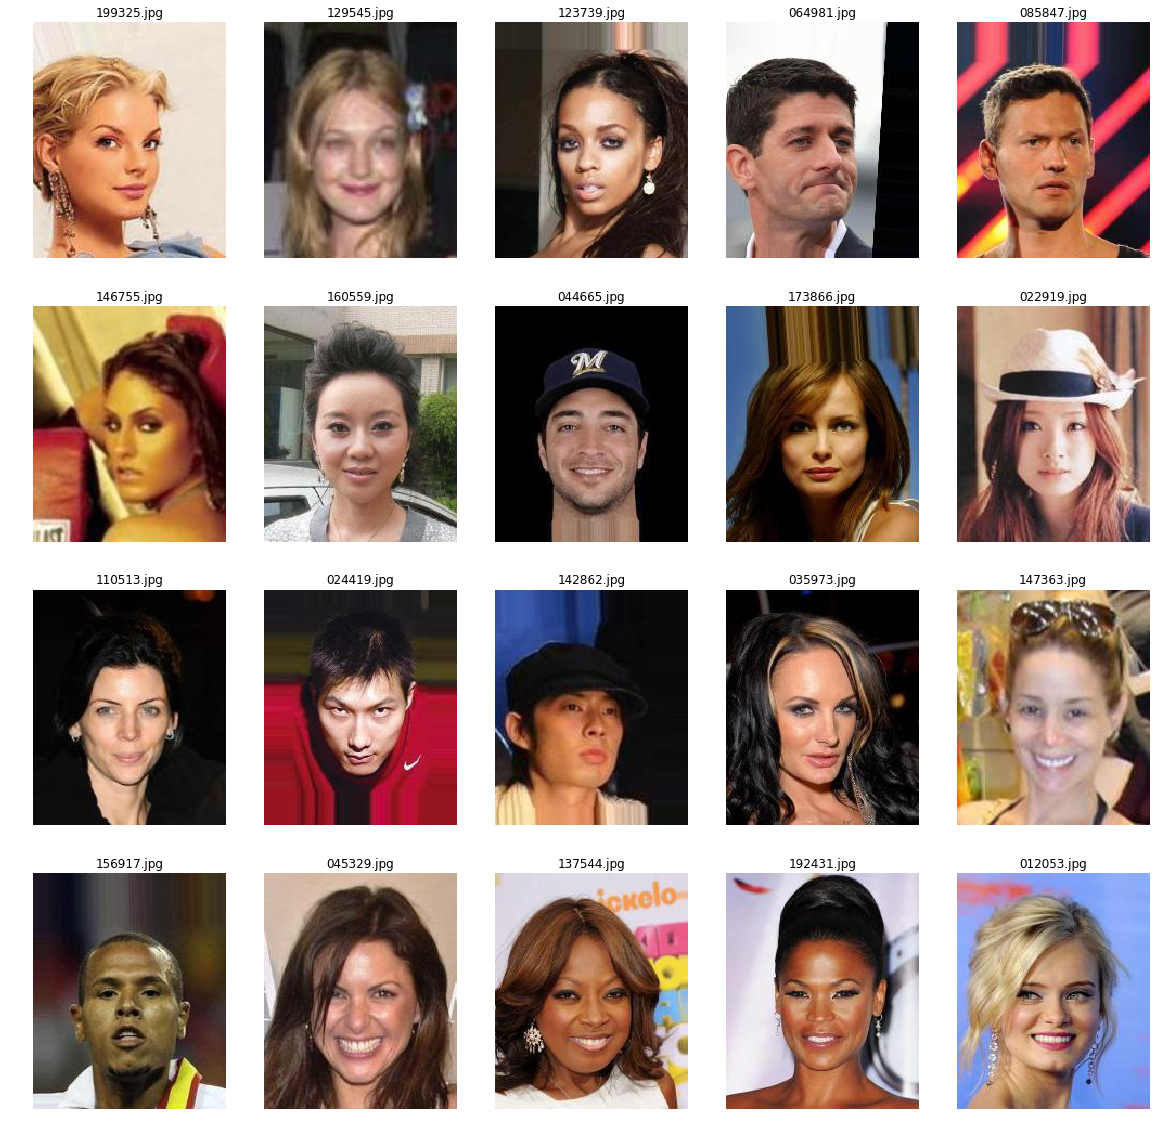

In [11]:
shapes = []

_,axs = plt.subplots(4,5, figsize = (20,20))

for i, num in enumerate(np.random.randint(low = 0, high = 202600, size = 20)):
    num = str(num)
    l = len(num)
    img = open_image('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/' + '0'*(6-l) + num + '.jpg')
    img.show(ax = axs[i//5, i%5], title = '0'*(6-l) + num + '.jpg')
    shapes.append(img.shape)

print("Image sizes:")
print(shapes[:5])

First of all, we notice that the image size seems to always be 178 x 218 (width x height; PyTorch has opposite conventions): indeed all images have been cropped to such size, in such a way to capture only the face of the celebrity. We also see that images come in a large variety of qualities, luminosities and backgrounds, and some of these differences may affect the performance of our automatic segmentation model.

### Portrait segmentation dataset

As we mentioned in the introduction, we cannot train a portrait segmentation model on the CelebA dataset itself since we do not have information about the ground truth segmentation of the images. What we do instead is to use another dataset, more precisely the one described in the paper [Deep Automatic Portrait Matting](http://xiaoyongshen.me/papers/deepmatting.pdf) (available at this [link](http://xiaoyongshen.me/webpages/webpage_automatting/)), which contains 2000 portrait images and the corresponding "alpha matte". Let us dive more in detail into this new dataset.

We downloaded the dataset in the 'segmentation' folder, which contains a ReadMe file and two image folders (training and testing/validation):

In [12]:
path_train = Path("/kaggle/input/segmentation/segmentation")
path_train.ls()

[PosixPath('/kaggle/input/segmentation/segmentation/training'),
 PosixPath('/kaggle/input/segmentation/segmentation/testing'),
 PosixPath('/kaggle/input/segmentation/segmentation/ReadMe.txt')]

From the ReadMe file we understand that the dataset comes with 1700 training images and 300 testing images, together with their "alpha matte":

In [13]:
print(open('/kaggle/input/segmentation/segmentation/ReadMe.txt', 'r').read())

***Summary***
This dataset contains 1700 training images and 300 testing images, along with their respective alpha matte.

This dataset is available upon request.

***Usage License***
Neither The Chinese University of Hong Kong nor any of the researchers involved can guarantee the correctness of the data, its suitability for any particular purpose, or the validity of results based on the use of the data set. The dataset may be used for any research purposes under the following conditions:

1.The user may not state or imply any endorsement from The Chinese University of Hong Kong.
2.The user must acknowledge the use of the dataset in publications resulting from the use of the dataset (see below for citation information).
3.The user may not redistribute the data without separate permission.
4.The user may not use this information for any commercial or revenue-bearing purposes without first obtaining permission from the owner.

In no event shall The Chinese University of Hong Kong, its af

The idea of **alpha matting** is that each image contains a foreground and a backround object; each pixel $i$ in the image $I$ is then assumed to be a linear combination of (unknown) RGB foreground ($F$) and background ($B$) colors:

$$I_i = \alpha_i F_i + (1 - \alpha_i) B_i \,, \;\;\;\;\;\; \alpha_i \in [0,1]$$

where $\alpha_i \in [0,1]$ (the alpha value) is a scalar value defining the pixel foreground opacity. Alpha matte of an image is then simply the collection of alpha values for all pixels.

For our problem however we are not really interested in predicting the alpha matte itself, but more simply we want to classify each pixel as foreground or background. A simple way to do this is to start from the alpha matte and declare that all pixels for which $\alpha_i < 0.5$ are background (and will be labeled as 0), while all pixels for which $\alpha_i > 0.5$ are foreground (and will be labeled as 1). In this way, from each alpha matte we can create what we may call a **binary mask** our ground truth segmentation, which can be used to train our automatic portrait segmentation model.

The 'training' and 'testing' folders of our dataset contain the original images together with their alpha matte (matte.png files) and binary masks (bin.png files). Original images and alpha matte were provided from the dataset creators, while we created binary masks from alpha mattes as described above. Let us show the first few file names in both folders:

In [14]:
sorted((path_train/'training').ls())[:6]

[PosixPath('/kaggle/input/segmentation/segmentation/training/00001.png'),
 PosixPath('/kaggle/input/segmentation/segmentation/training/00001_bin.png'),
 PosixPath('/kaggle/input/segmentation/segmentation/training/00001_matte.png'),
 PosixPath('/kaggle/input/segmentation/segmentation/training/00002.png'),
 PosixPath('/kaggle/input/segmentation/segmentation/training/00002_bin.png'),
 PosixPath('/kaggle/input/segmentation/segmentation/training/00002_matte.png')]

In [15]:
print('Number of training images in Portraits dataset:', len((path_train/'training').ls())//3)

Number of training images in Portraits dataset: 1700


In [16]:
sorted((path_train/'testing').ls())[:6]

[PosixPath('/kaggle/input/segmentation/segmentation/testing/00001.png'),
 PosixPath('/kaggle/input/segmentation/segmentation/testing/00001_bin.png'),
 PosixPath('/kaggle/input/segmentation/segmentation/testing/00001_matte.png'),
 PosixPath('/kaggle/input/segmentation/segmentation/testing/00002.png'),
 PosixPath('/kaggle/input/segmentation/segmentation/testing/00002_bin.png'),
 PosixPath('/kaggle/input/segmentation/segmentation/testing/00002_matte.png')]

In [17]:
print('Number of validation images in Portraits dataset:', len((path_train/'testing').ls())//3)

Number of validation images in Portraits dataset: 300


Let us also display one image from the testing folder, together with its alpha matte and binary mask:

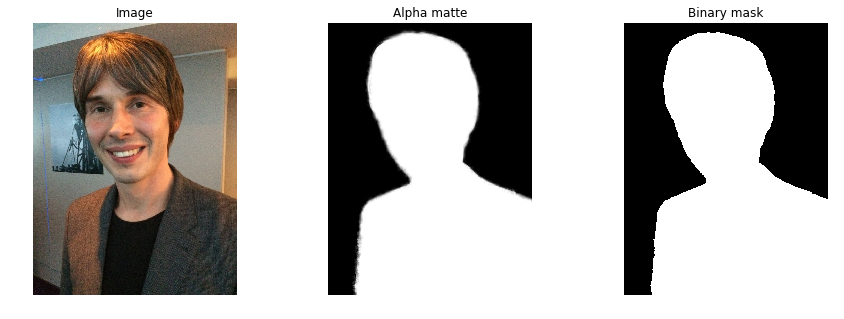

In [18]:
_,axs = plt.subplots(1,3, figsize = (15,5))

open_image(path_train/'testing/00001.png').show(axs[0], title = 'Image')
open_image(path_train/'testing/00001_matte.png').show(axs[1], title = 'Alpha matte')
Image(open_image(path_train/'testing/00001_bin.png').data*255).show(axs[2], title = 'Binary mask')

The size of all images is 600 x 800 (width x height) with three channels:

In [19]:
open_image(path_train/'testing/00001.png').shape

torch.Size([3, 800, 600])

Alpha matte are again 600 x 800, but with a single channel:

In [20]:
open_mask(path_train/'testing/00001_matte.png').shape

torch.Size([1, 800, 600])

We notice that alpha matte in this dataset are not given with values in the range [0,1] but as integers in the range [0,255]:

In [21]:
np.array(PIL.Image.open(path_train/'testing/00001_matte.png').getdata()).reshape(800,600)

array([[  0,   0,   0,   0, ...,   0,   0,   0,   0],
       [  0,   0,   0,   0, ...,   0,   0,   0,   0],
       [  0,   0,   0,   0, ...,   0,   0,   0,   0],
       [  0,   0,   0,   0, ...,   0,   0,   0,   0],
       ...,
       [  0,   0,   0,   0, ..., 255, 255, 255, 255],
       [  0,   0,   0,   0, ..., 255, 255, 255, 255],
       [  0,   0,   0,   0, ..., 255, 255, 255, 255],
       [  0,   0,   0,   0, ..., 255, 255, 255, 255]])

In [22]:
np.unique(np.array(PIL.Image.open(path_train/'testing/00001_matte.png').getdata()).reshape(800,600))

array([  0,   1,   2,   3, ..., 252, 253, 254, 255])

Binary masks are then created by labeling all pixels with alpha value $<$ 128 as 0 and all pixels with alpha value $\geqslant$ 128 as 1:

In [23]:
open_mask(path_train/'testing/00001_bin.png').shape

torch.Size([1, 800, 600])

In [24]:
np.array(PIL.Image.open(path_train/'testing/00001_bin.png').getdata()).reshape(800,600)

array([[0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, ..., 1, 1, 1, 1],
       [0, 0, 0, 0, ..., 1, 1, 1, 1],
       [0, 0, 0, 0, ..., 1, 1, 1, 1],
       [0, 0, 0, 0, ..., 1, 1, 1, 1]])

We can confirm that the only values appearing in the binary mask are 0 and 1 (differently from the alpha matte):

In [25]:
np.unique(np.array(PIL.Image.open(path_train/'testing/00001_bin.png').getdata()).reshape(800,600))

array([0, 1])

Let us now summarize the elements in our portraits segmentation dataset:

In [26]:
list_img_train = sorted([i for i in glob.glob('/kaggle/input/segmentation/segmentation/training/*') if (i[-5] != 'e' and i[-5] != 'n')])
list_mat_train = sorted([i for i in glob.glob('/kaggle/input/segmentation/segmentation/training/*') if i[-5] == 'e'])
list_bin_train = sorted([i for i in glob.glob('/kaggle/input/segmentation/segmentation/training/*') if i[-5] == 'n'])
print('Number of training images in Portraits dataset:      ', len(list_img_train))
print('Number of training alpha matte in Portraits dataset: ', len(list_mat_train))
print('Number of training binary masks in Portraits dataset:', len(list_bin_train))

print()

list_img_valid = sorted([i for i in glob.glob('/kaggle/input/segmentation/segmentation/testing/*') if (i[-5] != 'e' and i[-5] != 'n')])
list_mat_valid = sorted([i for i in glob.glob('/kaggle/input/segmentation/segmentation/testing/*') if i[-5] == 'e'])
list_bin_valid = sorted([i for i in glob.glob('/kaggle/input/segmentation/segmentation/testing/*') if i[-5] == 'n'])
print('Number of validation images in Portraits dataset:      ', len(list_img_valid))
print('Number of validation alpha matte in Portraits dataset: ', len(list_mat_valid))
print('Number of validation binary masks in Portraits dataset:', len(list_bin_valid))

Number of training images in Portraits dataset:       1700
Number of training alpha matte in Portraits dataset:  1700
Number of training binary masks in Portraits dataset: 1700

Number of validation images in Portraits dataset:       300
Number of validation alpha matte in Portraits dataset:  300
Number of validation binary masks in Portraits dataset: 300


To conclude, let us show a few more examples from the training folder:

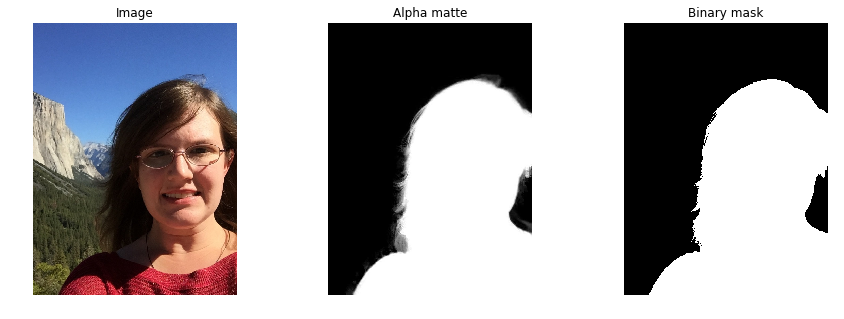

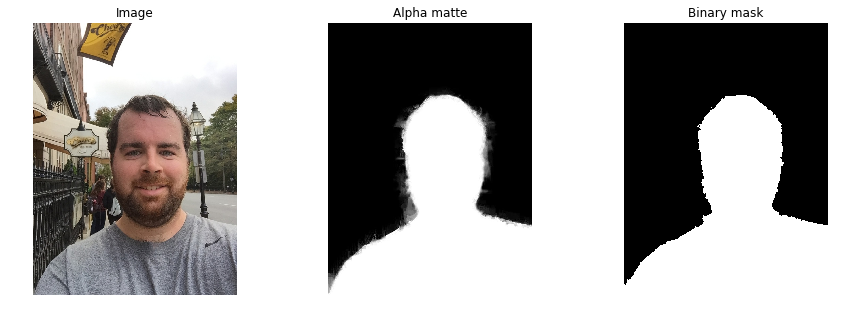

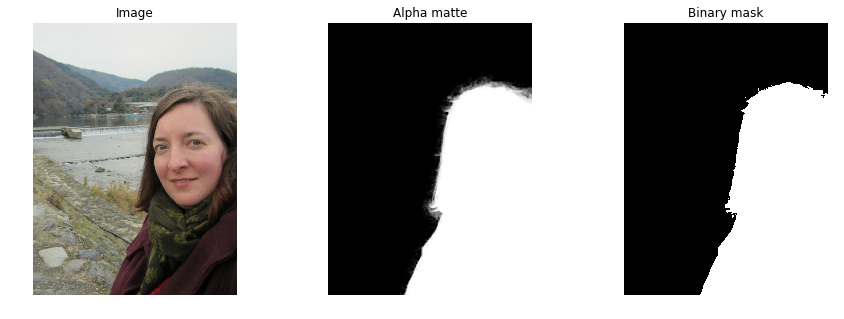

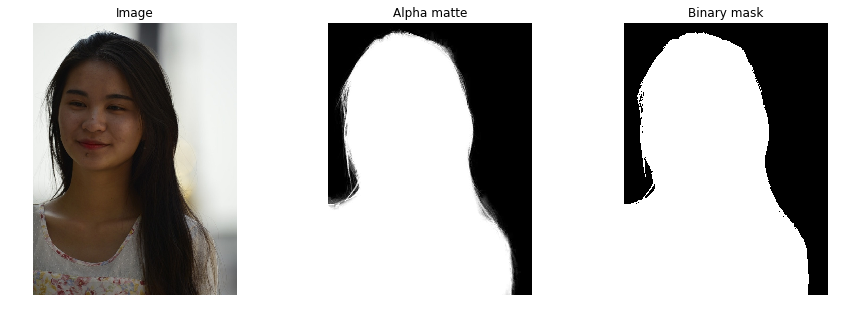

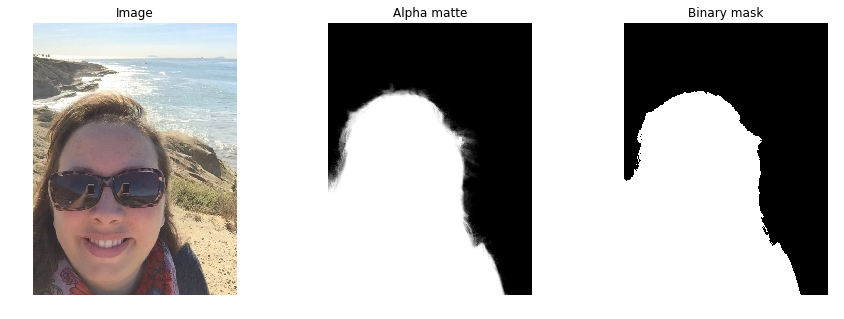

In [27]:
def show_portrait_train(num):
    _,axs = plt.subplots(1,3, figsize = (15,5))
    open_image(list_img_train[num]).show(ax = axs[0], title = 'Image')
    open_image(list_mat_train[num]).show(ax = axs[1], title = 'Alpha matte')
    Image(open_image(list_bin_train[num]).data*255).show(ax = axs[2], title = 'Binary mask')
    
for i in range(5):
    show_portrait_train(i)

***

# Model - U-Net

Having described our datasets, we should now construct a model which is able to automatically create a binary mask (or segmentation) given a portrait image. We take inspiration from the paper [Automatic Portrait Segmentation for Image Stylization](http://xiaoyongshen.me/webpage_portrait/papers/portrait_eg16.pdf). The idea in that paper is to simply use our portrait segmentation dataset (actually a slightly smaller version of it) to train a Fully Convolutional Network (FCN), taken from the paper [Fully convolutional networks for semantic segmentation](https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf) but with a few tweaks. The authors of the paper evaluated the segmentation error of their FCN model by computing the **Intersection-over-Union (IoU)** accuracy, i.e. the area of intersection of the predicted segmentation with the ground truth segmentation divided by the union of their areas:  

$$\text{IoU} = \dfrac{\text{area}\,(\text{output} ∩ \text{ground truth})}{\text{area}\,(\text{output} ∪ \text{ground truth})}$$

Their best model was able to reach 95.91% mean IoU on the test set, indicating that on average the predicted segmentation is quite close to the ground truth. They however only show the predicted segmentations for the cases with highest IoU, so we cannot determine when their model fails and how it may be improved (although they mention that their model may fail when the background and foreground have very small contrast). 

We will follow the same idea as in that paper, but replace the FCN with a **U-Net** [convolutional network](https://arxiv.org/abs/1505.04597) which has been shown to be very efficient for segmentation tasks.
Usually, convolutional networks take an image and, through many convolutional layers, decrease its size while creating many feature channels, thus providing an encoded representation of an image. U-Nets instead first go through the same encoding process, but later increase the image size via deconvolutional layers until the original image size is recovered, basically reversing the encoding path; in the process, several concatenating skip connections are added between downsampling and upsampling layers, which help in dealing with fine image details.

Such an U-Net can be easily constructed with the fastai library. We should first create a databunch object appropriate for image segmentation; this is done in various steps where we specify:

* Where the file names and the images are, by calling the `from_folder()` method and indicating the path location of our data;


* Which files we should consider (i.e. only images, not alpha matte or binary masks), by calling the `filter_by_function()` method;


* How to split our data into training and validation, with `split_by_folder()`;


* What the file names of the binary masks (our labels) are, using `label_from_func()` (we should also indicate a name for the pixel labels such as background and foreground);


* How we want to resize the images (218 x 178 to match with CelebA standards) and which transformations we want to apply for data augmentation (in our case the standard set of transformations given by `get_transforms()`: horizontal flip, rotations up to $\pm 10$  degrees, zoom up to 110%, warp and contrast change).

We finally explicitly create the DataBunch object and specify the batch size `bs`, and normalize the pixel intensities of our images according to the normalization used for pre-training on the ImageNet dataset. The final result is as follows:

In [28]:
# we need to specify the classes label: 0 will be background, 1 will be foreground

codes = np.array(['B', 'F'])

data = (SegmentationItemList.from_folder(path = path_train)
        # ignore "_matte.png" and "_bin.png" files
       .filter_by_func(lambda fname: Path(fname).name[-5] != 'e' and Path(fname).name[-5] != 'n')
        # train/validation split
       .split_by_folder(train = 'training', valid = 'testing')
        # associate "_bin.png" files as label to an image
       .label_from_func(lambda x: '/kaggle/input/segmentation/segmentation/' 
                        + (path_train/x).parts[-2] + '/' + (path_train/x).name[:-4] + '_bin.png', classes = codes)
        # apply transformations (also to segmentations, i.e. labels y) and resize to CelebA size
       .transform(get_transforms(), tfm_y = True, size = (218,178))
        # create a databunch object with batches of 4 elements
       .databunch(bs = 4)
        # use standard imagenet normalization
       .normalize(imagenet_stats))

data

ImageDataBunch;

Train: LabelList (1700 items)
x: SegmentationItemList
Image (3, 218, 178),Image (3, 218, 178),Image (3, 218, 178),Image (3, 218, 178),Image (3, 218, 178)
y: SegmentationLabelList
ImageSegment (1, 218, 178),ImageSegment (1, 218, 178),ImageSegment (1, 218, 178),ImageSegment (1, 218, 178),ImageSegment (1, 218, 178)
Path: /kaggle/input/segmentation/segmentation;

Valid: LabelList (300 items)
x: SegmentationItemList
Image (3, 218, 178),Image (3, 218, 178),Image (3, 218, 178),Image (3, 218, 178),Image (3, 218, 178)
y: SegmentationLabelList
ImageSegment (1, 218, 178),ImageSegment (1, 218, 178),ImageSegment (1, 218, 178),ImageSegment (1, 218, 178),ImageSegment (1, 218, 178)
Path: /kaggle/input/segmentation/segmentation;

Test: None

We should also define an appropriate evaluation metric, in our case the Intersection-over-Union (IoU) accuracy; this can be done by setting `iou = True` in the fastai `dice()` metric:

In [29]:
def iou(input, targs):
    return dice(input, targs, iou = True)

At this point we can create our U-Net based on a ResNet-50 encoder pre-trained on ImageNet, also setting a weight decay 0.01 for regularization (we found ResNet-50 to perform slightly better than other architectures):

In [30]:
learn = unet_learner(data, models.resnet50, wd = 1e-2, metrics = iou, model_dir = '/kaggle/working/models')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.torch/models/resnet50-19c8e357.pth
102502400it [00:00, 107363644.46it/s]


The method `lr_find()` helps us choosing the best learning rate, telling us for which learning rate the loss function decreases faster:

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


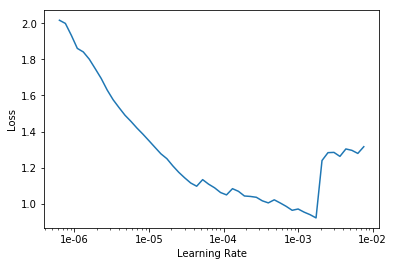

In [31]:
learn.lr_find()
learn.recorder.plot()

We can train the last layers of the model for a few epochs:

In [32]:
learn.fit_one_cycle(8, slice(3e-5), pct_start = 0.8)

Train and validation losses consistently decrease, while the IoU metric increases:

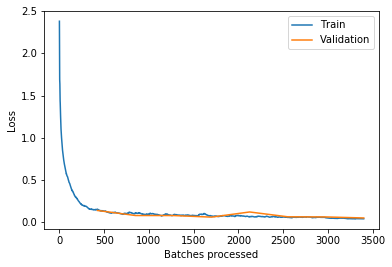

In [33]:
learn.recorder.plot_losses()

In [34]:
# IoU values per epoch

learn.recorder.metrics

[[tensor(0.9155)],
 [tensor(0.9535)],
 [tensor(0.9531)],
 [tensor(0.9647)],
 [tensor(0.9391)],
 [tensor(0.9669)],
 [tensor(0.9671)],
 [tensor(0.9721)]]

In [35]:
# Validation losses per epoch

learn.recorder.val_losses

[0.13663262,
 0.07680901,
 0.07642106,
 0.057787552,
 0.11885686,
 0.061692346,
 0.059997674,
 0.04781699]

At this point we can unfreeze all layers and train the whole model for a few more epochs:

In [36]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


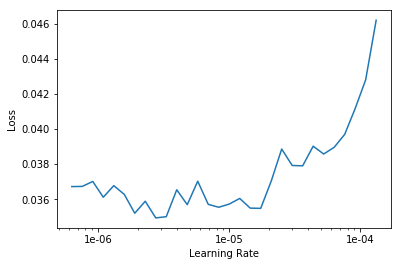

In [37]:
learn.lr_find()
learn.recorder.plot()

In [38]:
learn.fit_one_cycle(16, slice(1e-6, 1e-5))

The validation loss and IoU metric seem to have stabilized:

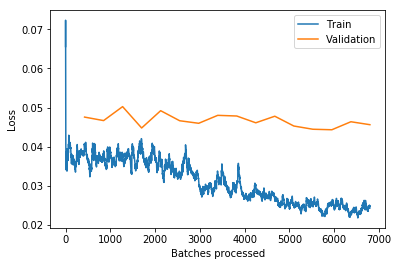

In [39]:
learn.recorder.plot_losses()

In [40]:
# IoU values per epoch

learn.recorder.metrics

[[tensor(0.9724)],
 [tensor(0.9725)],
 [tensor(0.9717)],
 [tensor(0.9740)],
 [tensor(0.9737)],
 [tensor(0.9733)],
 [tensor(0.9744)],
 [tensor(0.9739)],
 [tensor(0.9735)],
 [tensor(0.9750)],
 [tensor(0.9752)],
 [tensor(0.9765)],
 [tensor(0.9762)],
 [tensor(0.9766)],
 [tensor(0.9761)],
 [tensor(0.9762)]]

In [41]:
# Validation losses per epoch

learn.recorder.val_losses

[0.04756641,
 0.046675213,
 0.05023703,
 0.044787876,
 0.049200438,
 0.046634946,
 0.045985743,
 0.04801136,
 0.04784373,
 0.046112243,
 0.047788415,
 0.045290094,
 0.044466477,
 0.044335898,
 0.046378102,
 0.04562743]

***

# Interpretation

After training, we reached a mean IoU of 97.6% on the validation set; the mean IoU on the training set is instead 98.6%:

In [42]:
ious_train = []

for i in range(1700):
    
    # predicted segmentation, reshaped to array
    
    inp = learn.predict(open_image(list_img_train[i]))[2]
    inp = inp.argmax(dim = 0).view(1,-1)
    
    # ground truth segmentation, reshaped to array

    targs = open_mask(list_bin_train[i]).resize(size = (1,218,178)).data
    targs = targs.view(1, -1)
    
    # compute IoU and append in list

    intersect = (inp*targs).sum().float()
    union = (inp + targs).sum().float()

    ious_train.append(intersect/(union - intersect))
    
np.array(ious_train).mean()

0.9861167

To better understand our model, we should examine the most poorly segmented instances. Let us therefore create a list which sorts validation images based on their IoU: 

In [43]:
ious_valid = []

for i in range(300):
    inp = learn.predict(open_image(list_img_valid[i]))[2]
    inp = inp.argmax(dim = 0).view(1,-1)

    targs = open_mask(list_bin_valid[i]).resize(size = (1,218,178)).data
    targs = targs.view(1, -1)

    intersect = (inp*targs).sum().float()
    union = (inp + targs).sum().float()

    ious_valid.append(intersect/(union - intersect))
    
np.array(ious_valid).mean()

0.97639453

In [44]:
valid_sort = sorted(enumerate(np.array(ious_valid)), key = lambda x: x[1])    # sort by IoU
valid_sort[:10]

[(135, 0.8451278),
 (110, 0.8520593),
 (264, 0.8669001),
 (217, 0.8766995),
 (160, 0.8799446),
 (31, 0.8952566),
 (157, 0.90574706),
 (249, 0.92050064),
 (221, 0.921828),
 (139, 0.92498773)]

We can create a function to compare the predicted  and ground truth segmentation, portrait (foreground) and background:

In [45]:
def show_portrait_valid_results(i):
    
    _,axs = plt.subplots(1,7, figsize = (22,12))
    
    data_pred = learn.predict(open_image(list_img_valid[i]))[0].data
    
    data_bin = open_mask(list_bin_valid[i]).resize(size = (1,218,178)).data

    data_img = open_image(list_img_valid[i]).resize(size = (3,218,178)).data
    
    Image(data_pred).show(figsize = (5,5), ax = axs[0], title = 'Predicted segmentation', cmap = 'Paired')
    
    Image(data_bin).show(figsize = (5,5), ax = axs[1], title = 'Actual segmentation', cmap = 'Paired')
    
    Image(data_img*data_pred.float()).show(figsize = (5,5), ax = axs[2], title = 'Predicted portrait')
    
    Image(data_img*data_bin.float()).show(figsize = (5,5), ax = axs[3], title = 'Actual portrait')

    Image(data_img*(1-data_pred).float()).show(figsize = (5,5), ax = axs[4], title = 'Predicted background')
    
    Image(data_img*(1-data_bin).float()).show(figsize = (5,5), ax = axs[5], title = 'Actual background')
    
    Image(data_img).show(figsize = (5,5), ax = axs[6], title = 'Original image')

It is now easier to visualize the ten most poorly segmented images:

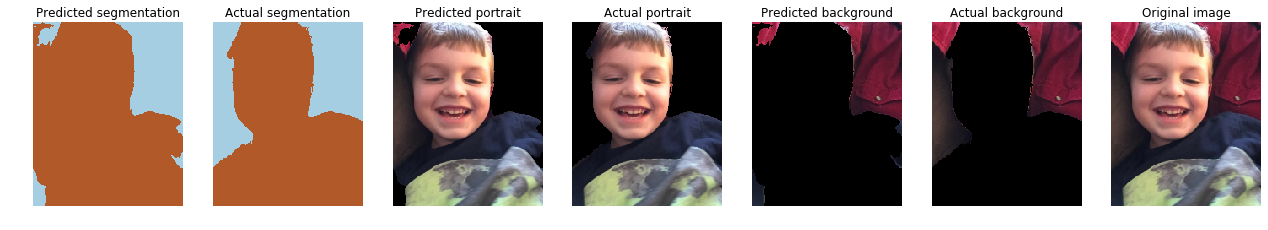

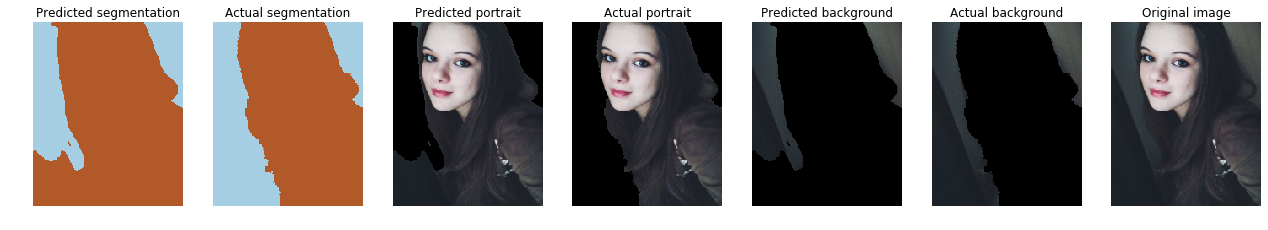

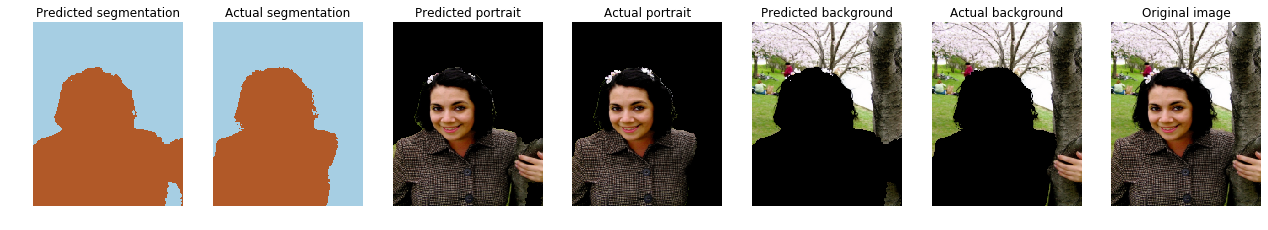

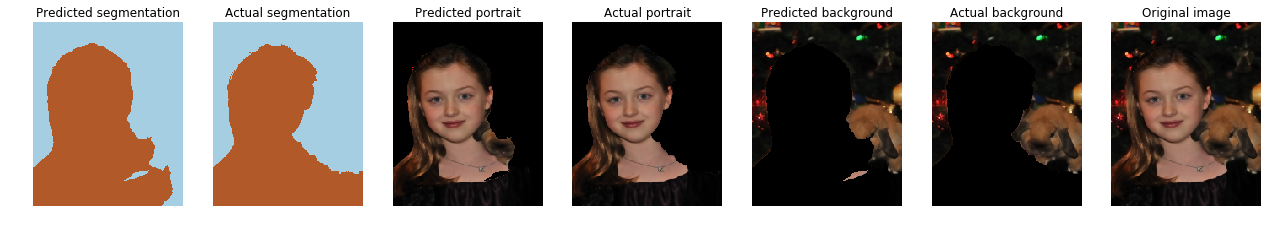

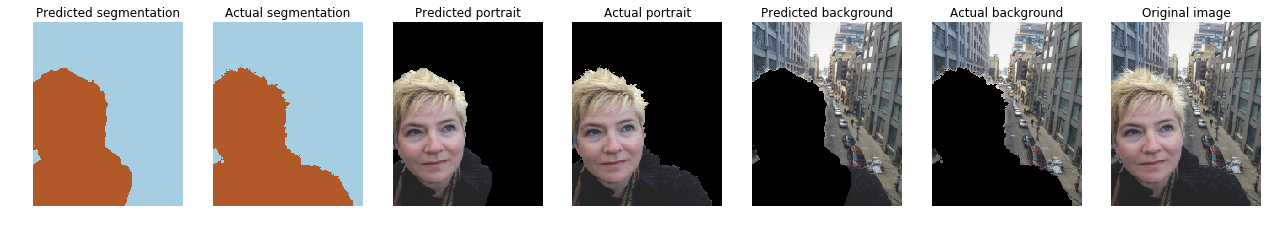

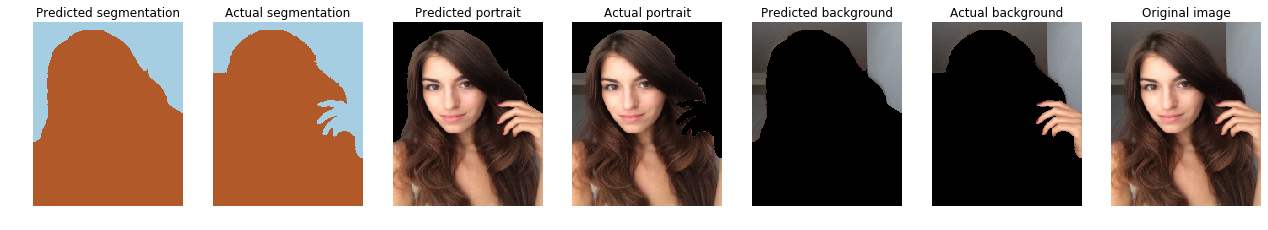

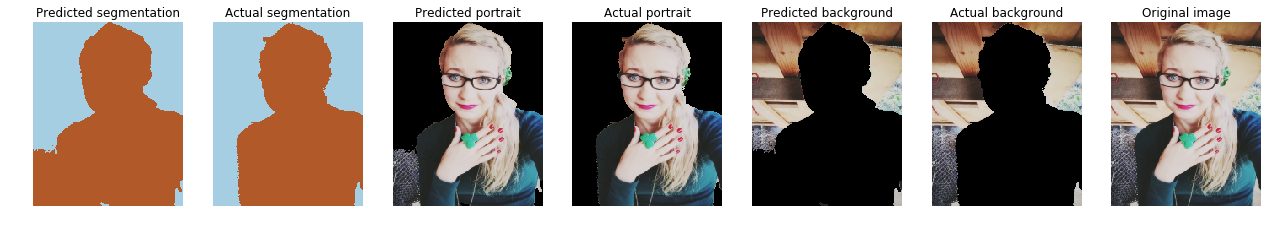

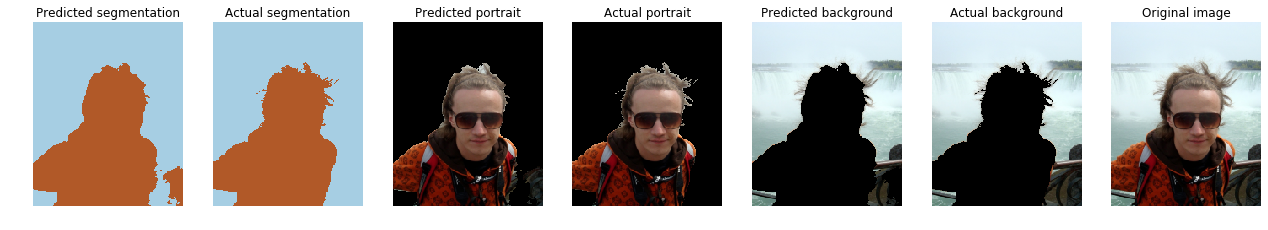

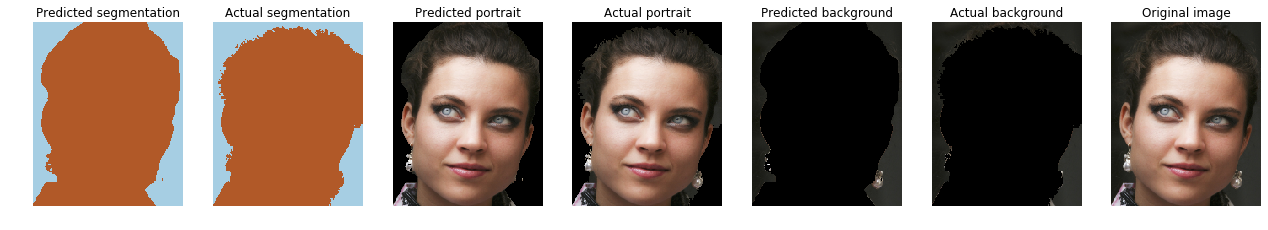

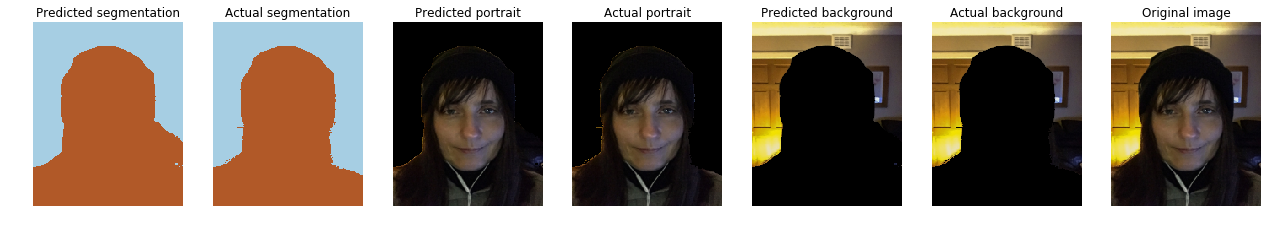

In [46]:
for el in [el[0] for el in valid_sort[:10]]:
    show_portrait_valid_results(el)

As we can see, in a couple of cases the IoU is low because the ground truth segmentation is not optimal and misses the hand of the subject: our model instead is able to include the hand correctly. In another case, the problem is due to the fact that both a person and a dog are foreground, and the model seems not to be completely sure about what to do with the dog. For the remaining instances, problems seem to appear when background and foreground have small contrast, as already mentioned in the Automatic Portrait Segmentation for Image Stylization paper we discussed earlier; in addition, fine hair details are often missed.

Let us also give a look at the ten best segmented images:

In [47]:
valid_sort[-10:]

[(104, 0.99607605),
 (215, 0.99621755),
 (194, 0.9962219),
 (165, 0.9963104),
 (128, 0.9965198),
 (202, 0.9968933),
 (136, 0.9973272),
 (74, 0.9975771),
 (206, 0.9978235),
 (210, 0.99861366)]

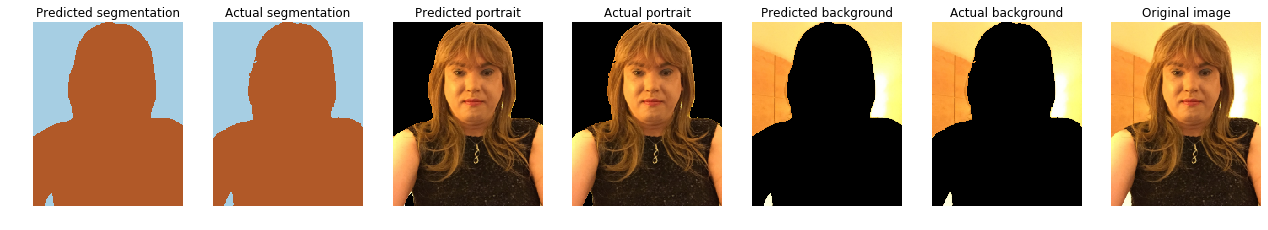

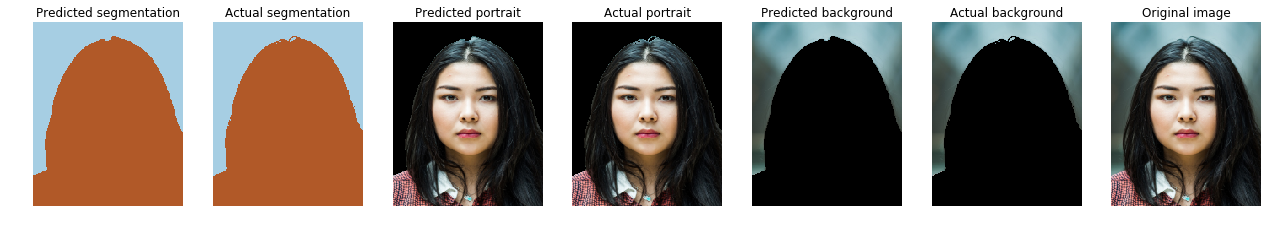

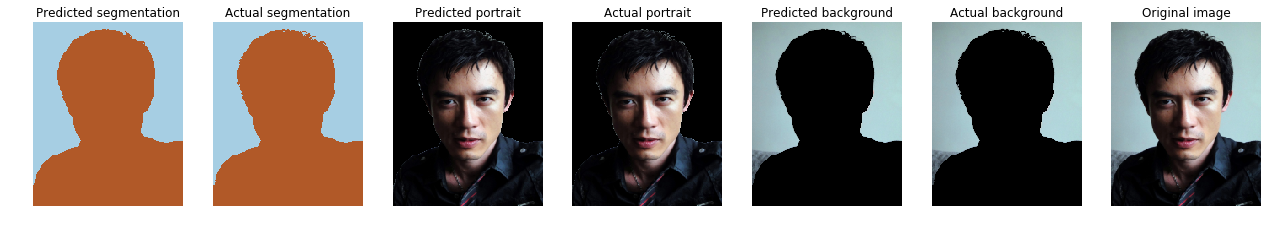

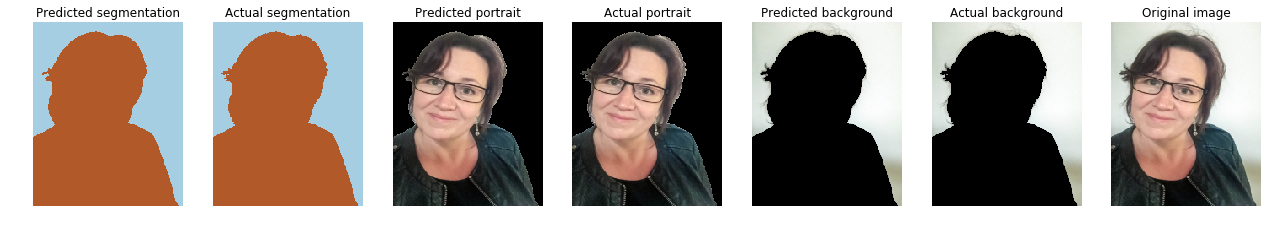

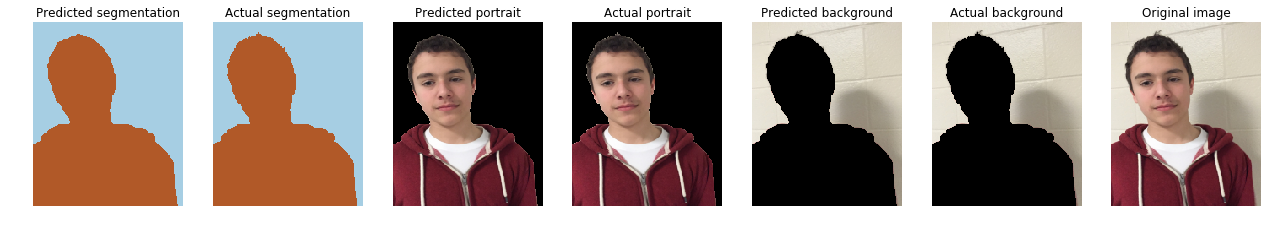

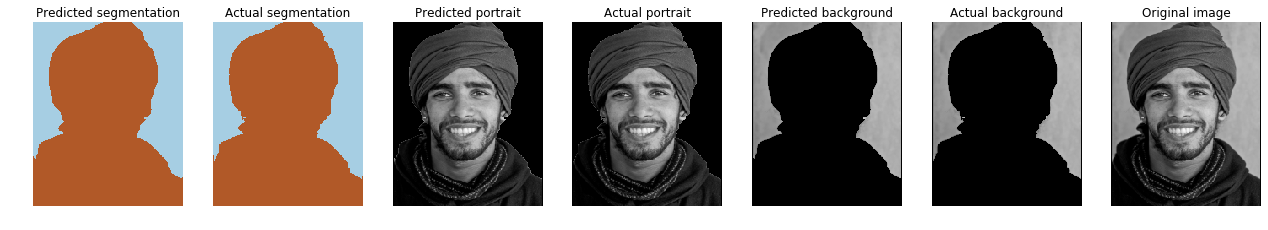

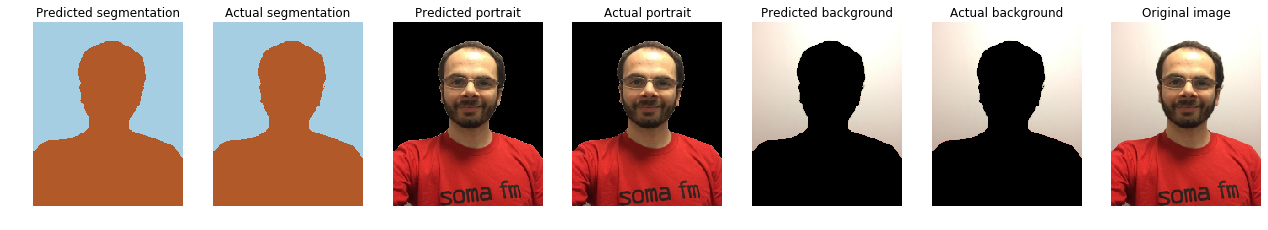

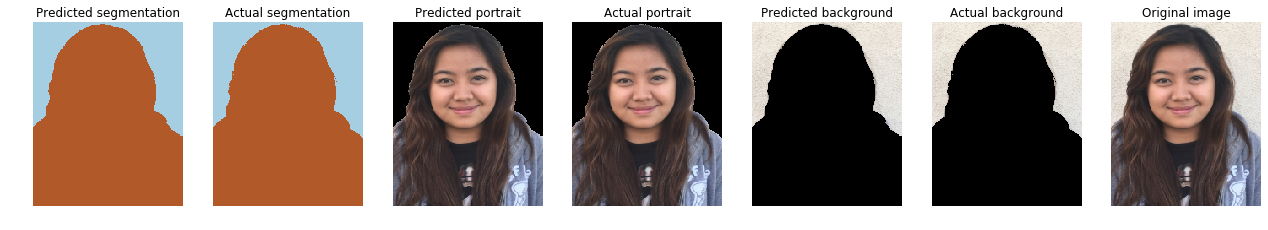

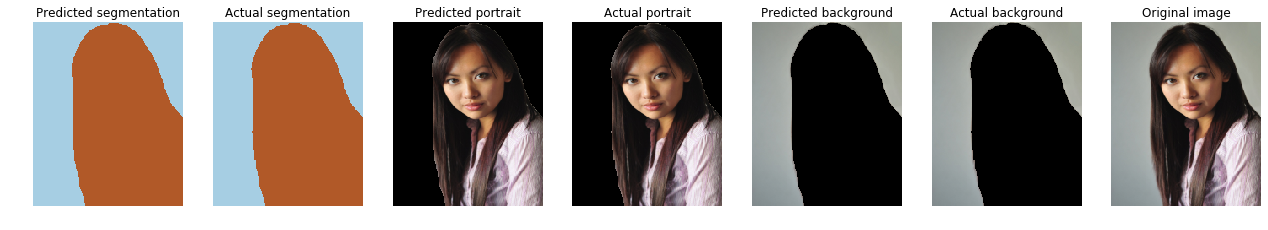

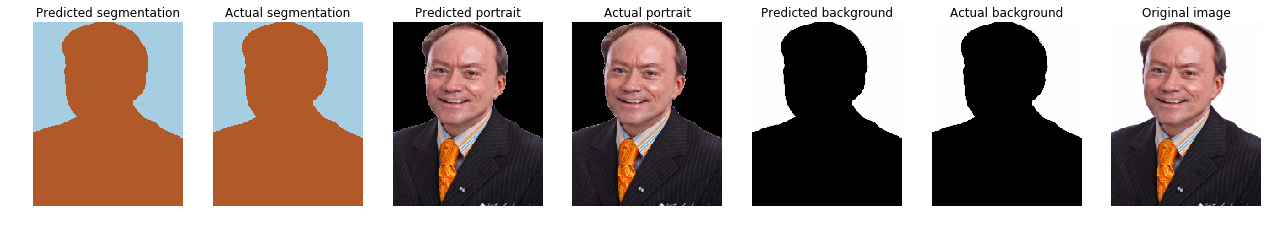

In [48]:
for el in [el[0] for el in valid_sort[-10:]]:
    show_portrait_valid_results(el)

In all these cases the background is very simple and clearly different from the portrait, and hair styles are also pretty simple: this confirms that background/foreground contrast and fine hair details are the biggest cause of bad automatic segmentation.

### Application to CelebA dataset

Now that we created an automatic portrait segmentation model, we can apply it to the CelebA dasaset as required from our exercise and examine how it performs. First of all, let us create a small function to visualize the predicted segmentation, portrait, background and the original image:

In [49]:
# possible num:
# 1-162770 training
# 162771-182637 validation
# 182638-202599 testing

def show_celeba_results(num):
    
    _,axs = plt.subplots(1,4, figsize = (14,10))
    
    file_name = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/' + num + '.jpg'
    
    data_pred = learn.predict(open_image(file_name))[0].data

    data_img = open_image(file_name).data
    
    Image(data_pred).show(figsize = (5,5), ax = axs[0], title = 'Predicted segmentation', cmap = 'Paired')
    
    Image(data_img*data_pred.float()).show(figsize = (5,5), ax = axs[1], title = 'Predicted portrait')

    Image(data_img*(1-data_pred).float()).show(figsize = (5,5), ax = axs[2], title = 'Predicted background')
    
    Image(data_img).show(figsize = (5,5), ax = axs[3], title = 'Original image')

We cannot compute the IoU for the CelebA dataset since we do not have the ground truth segmentations, but we can visualize the predictions for a random subset (say 50) of CelebA images and compare them against the original image:

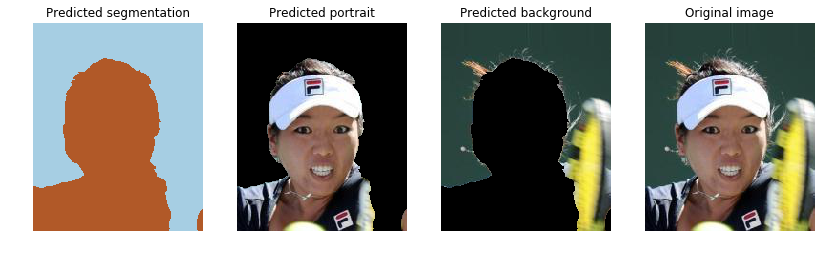

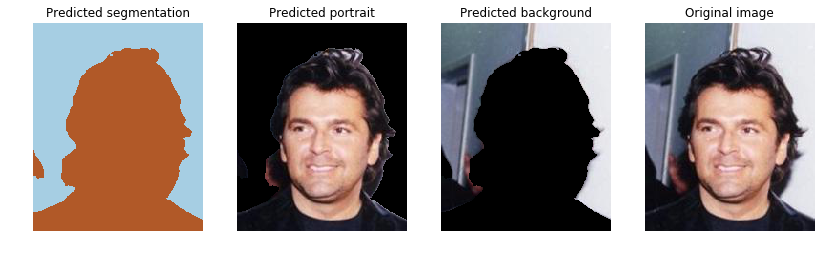

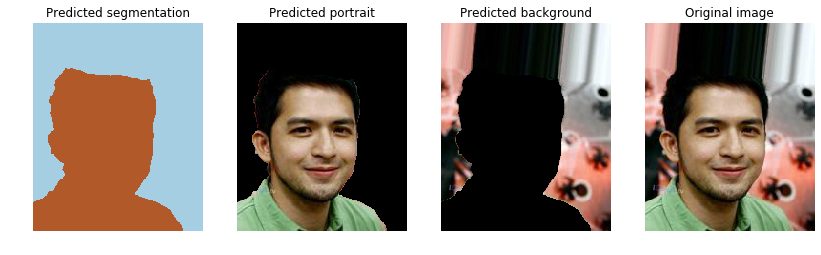

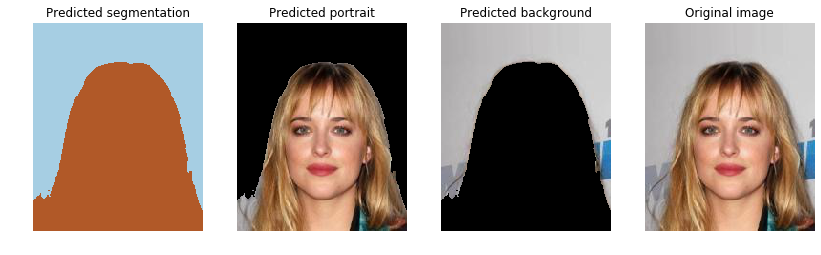

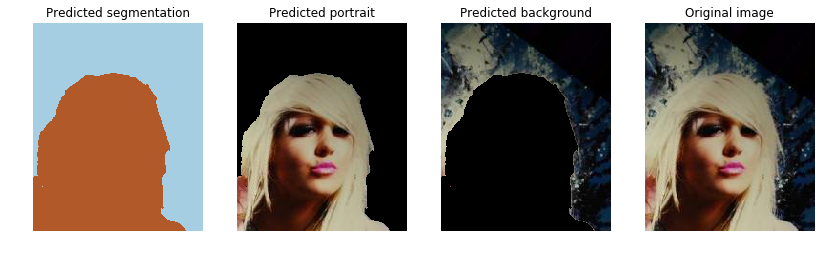

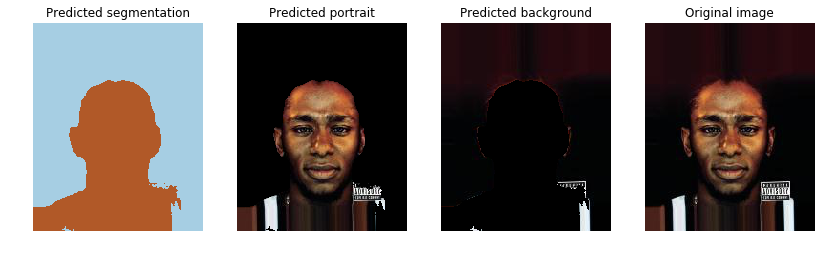

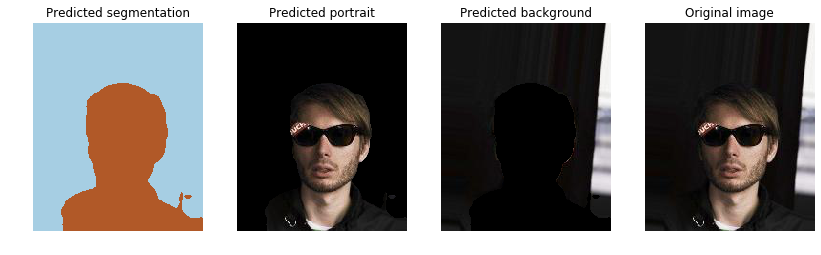

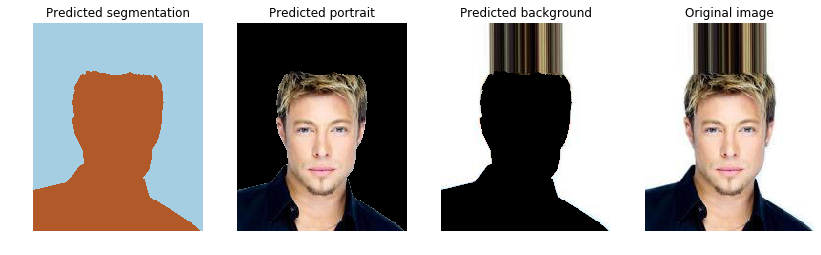

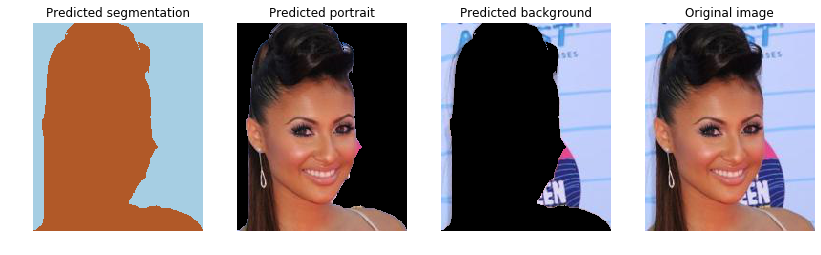

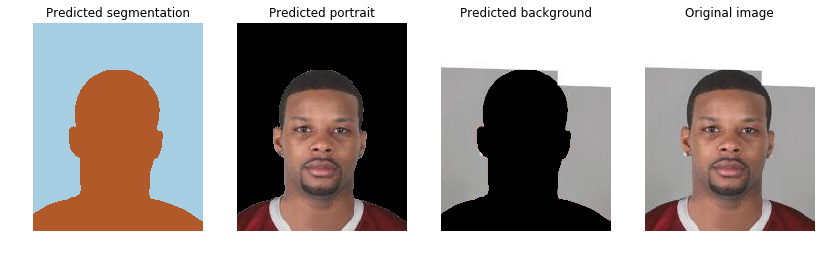

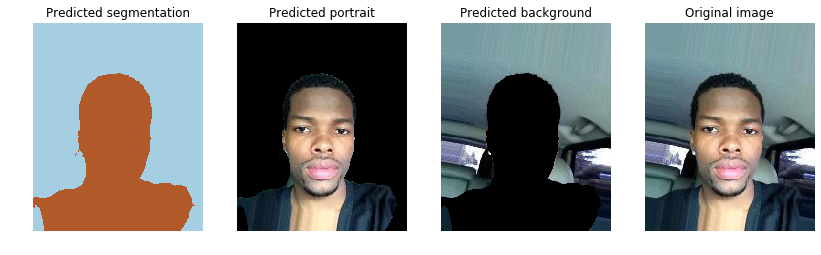

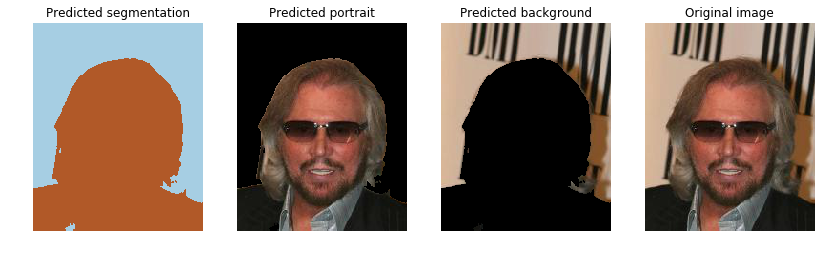

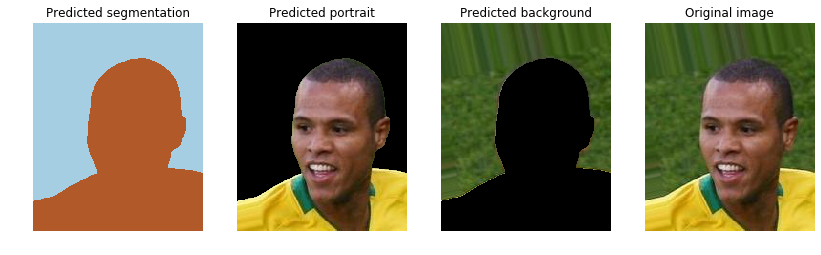

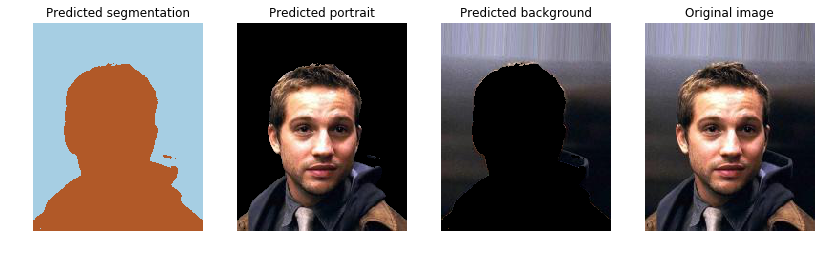

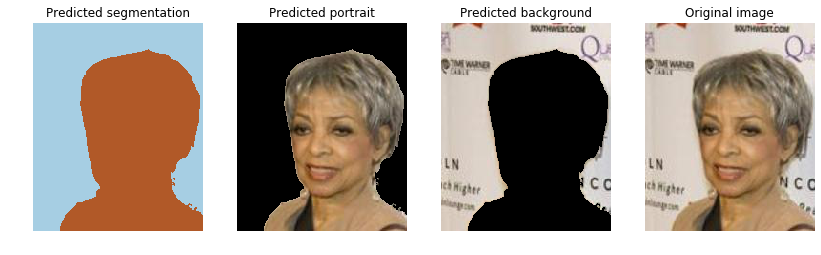

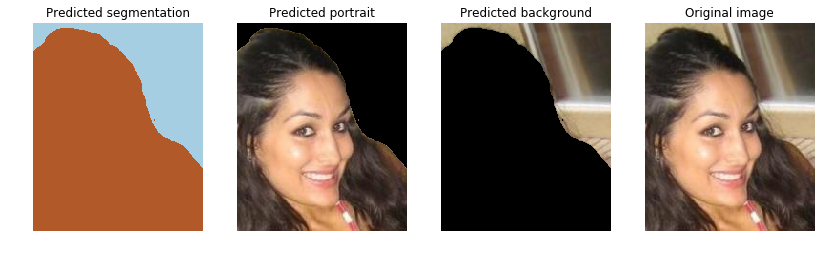

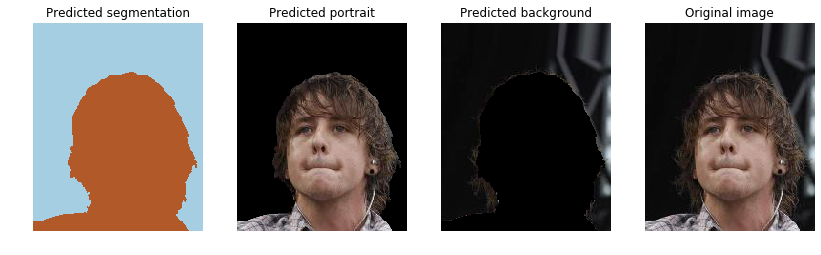

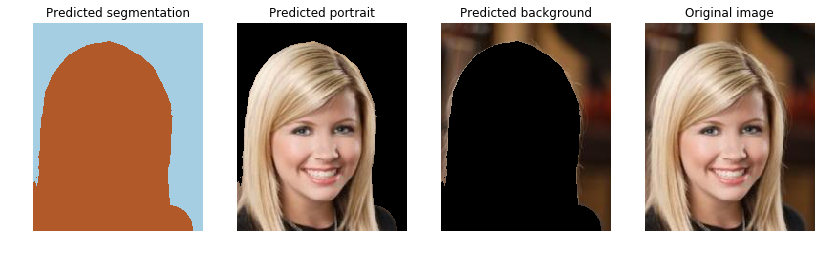

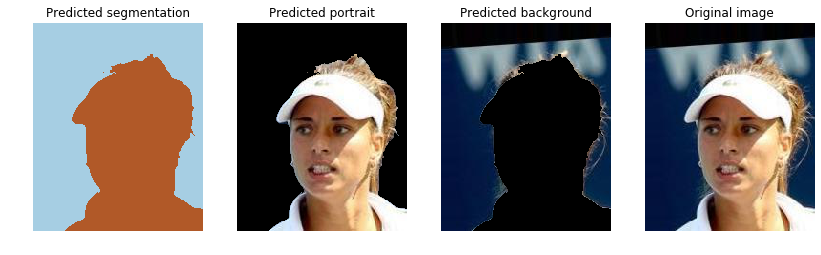

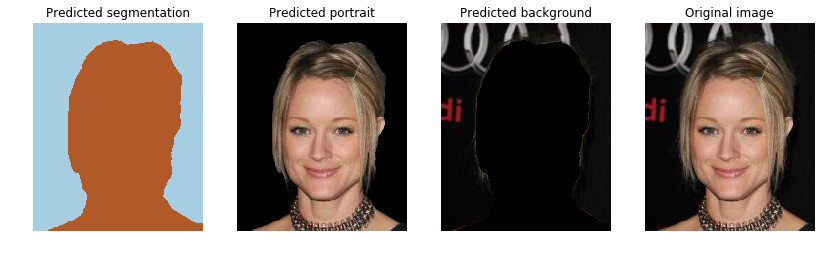

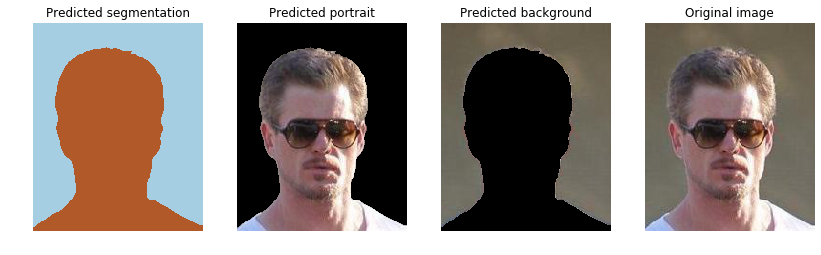

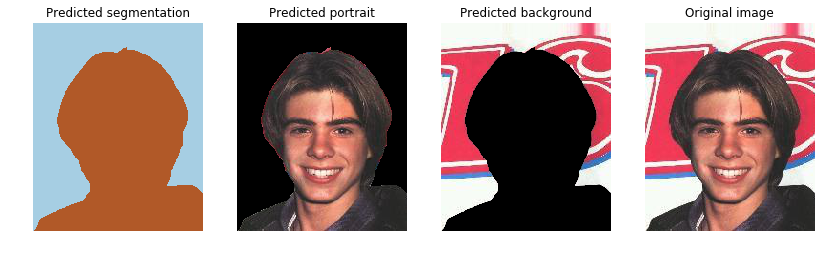

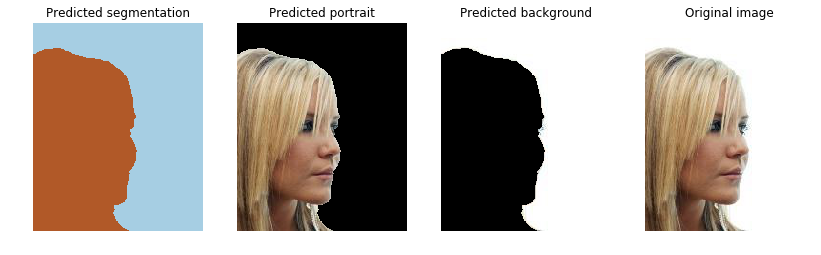

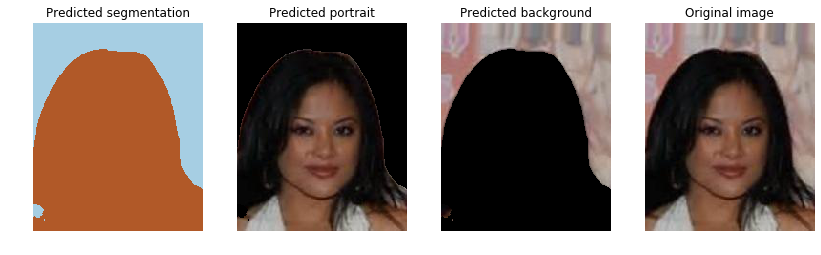

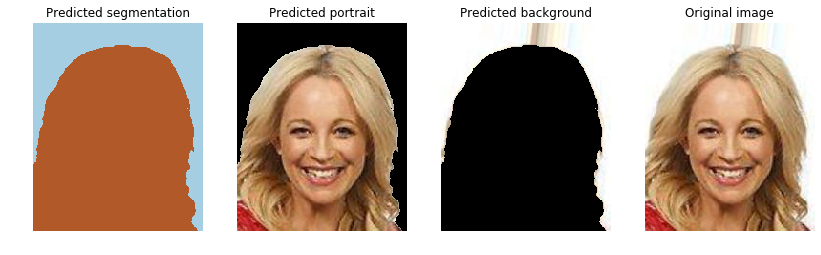

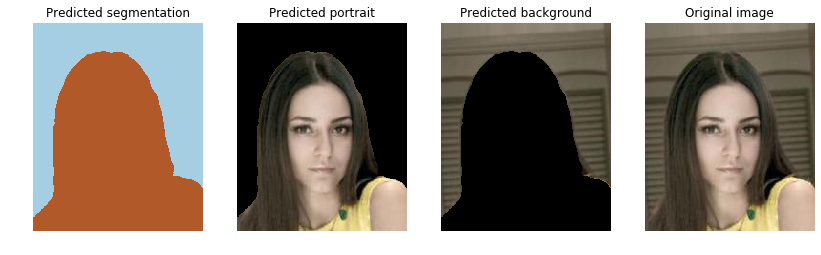

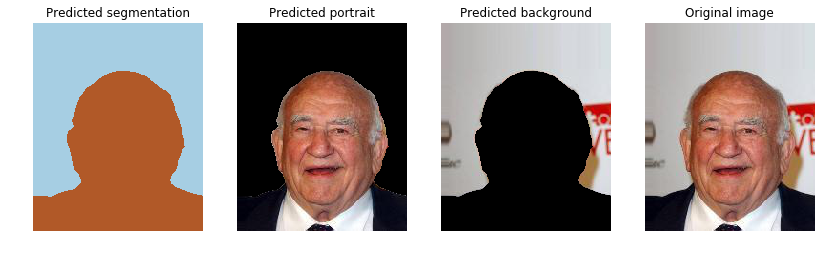

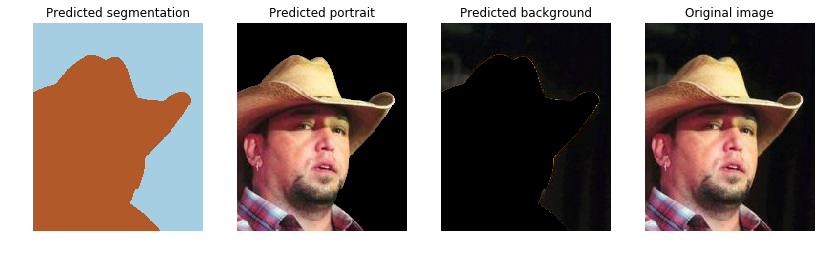

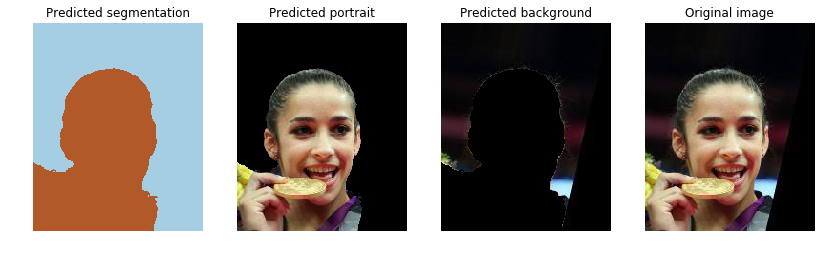

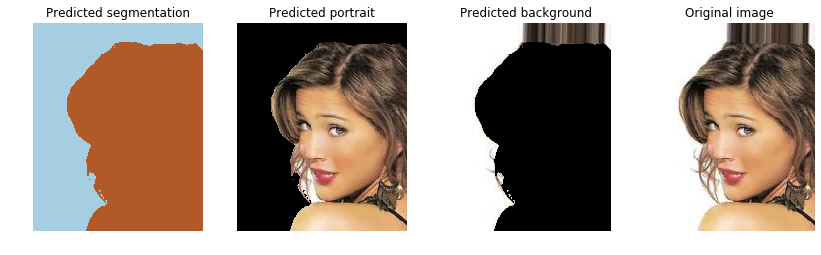

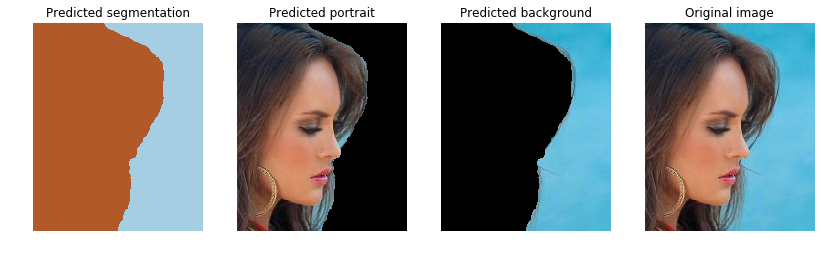

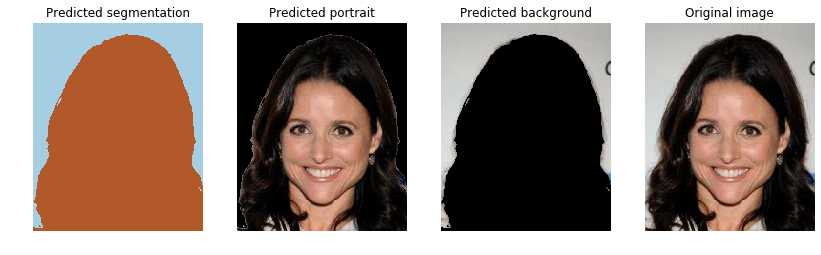

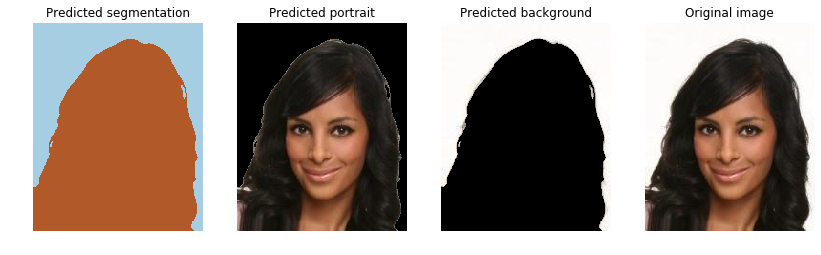

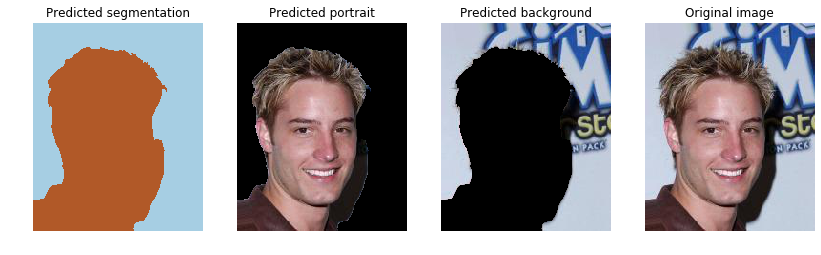

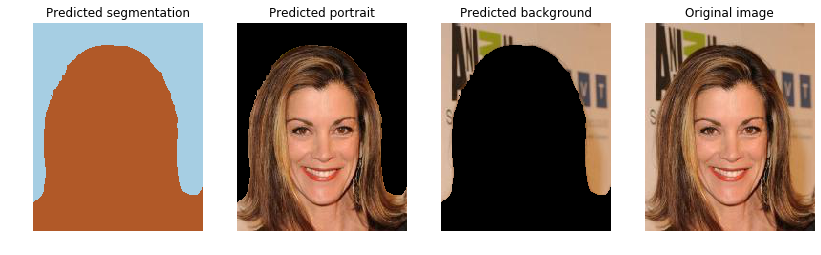

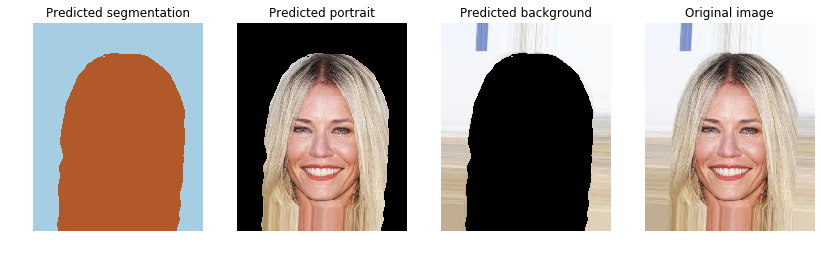

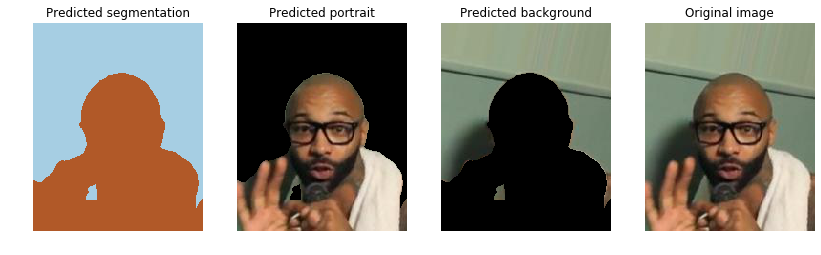

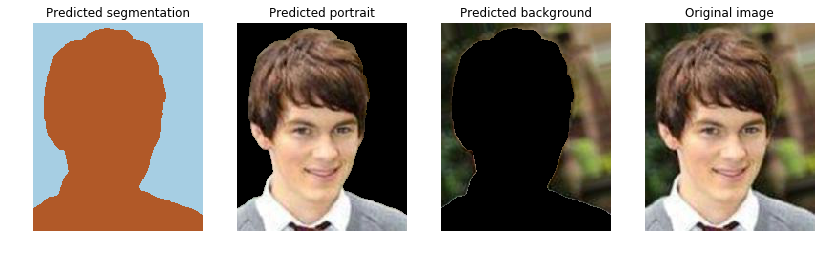

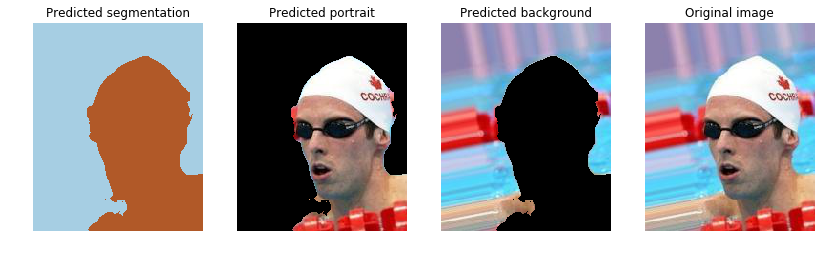

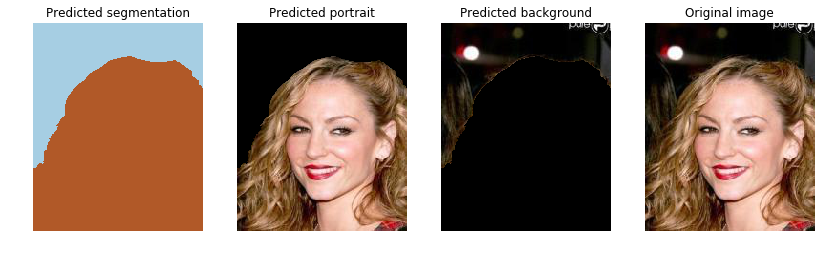

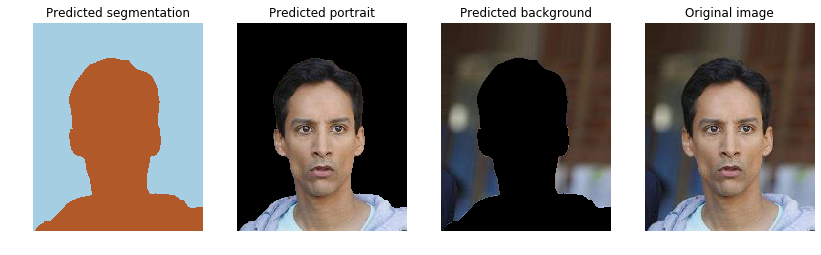

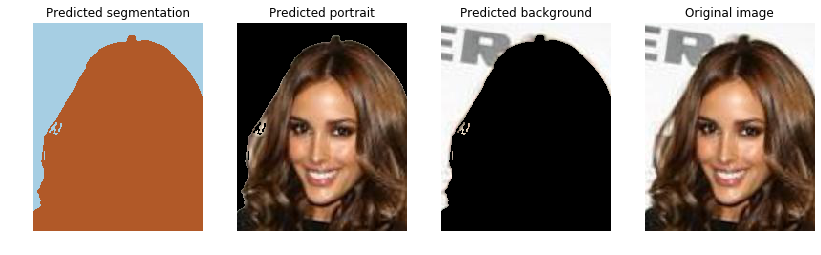

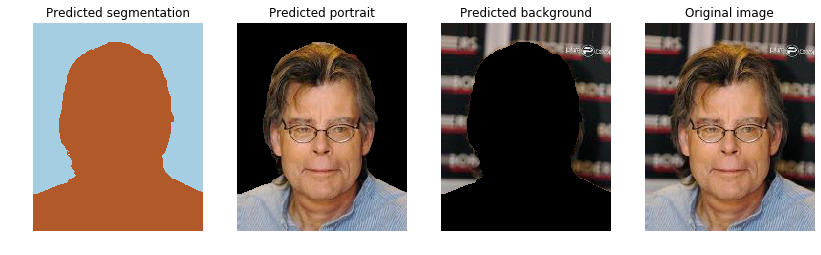

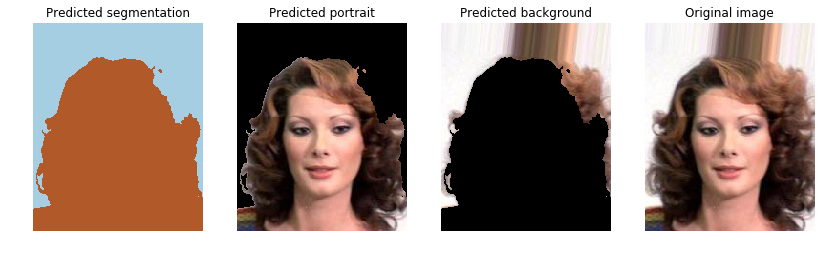

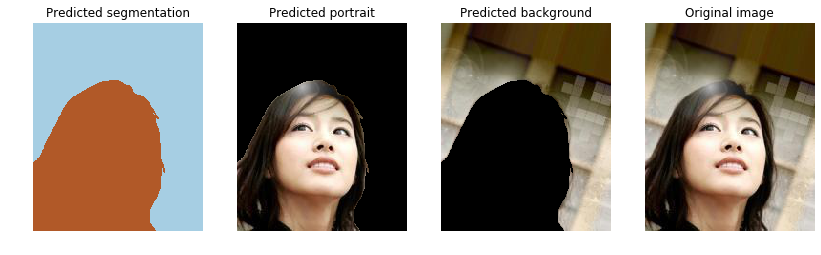

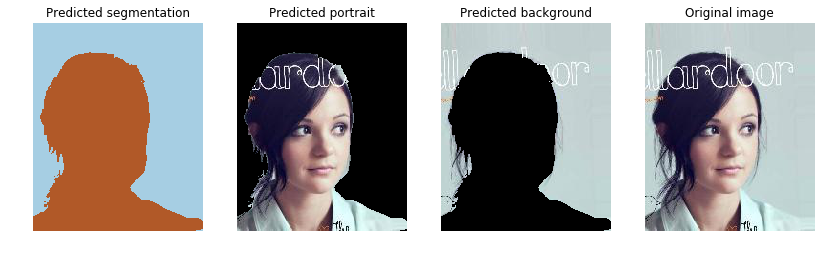

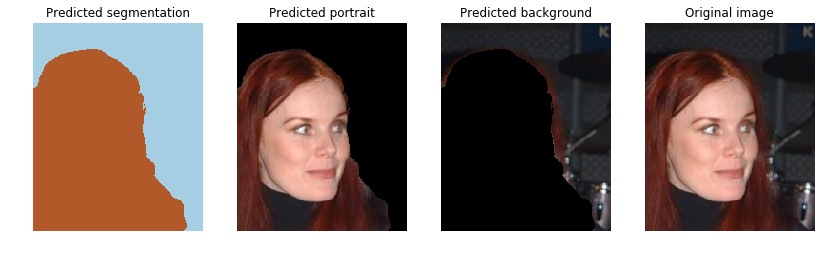

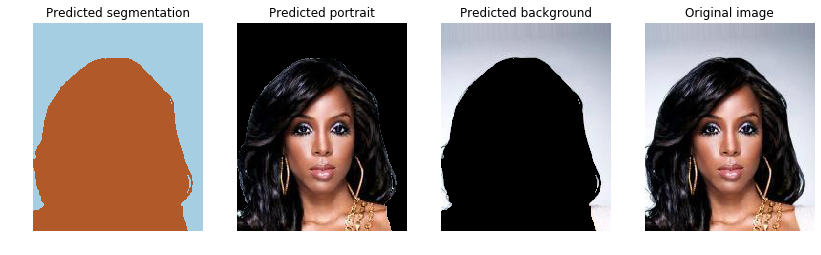

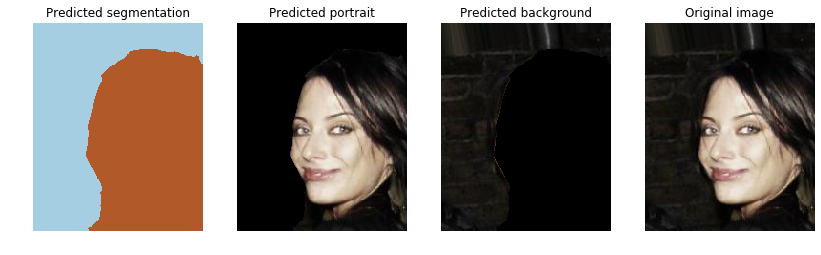

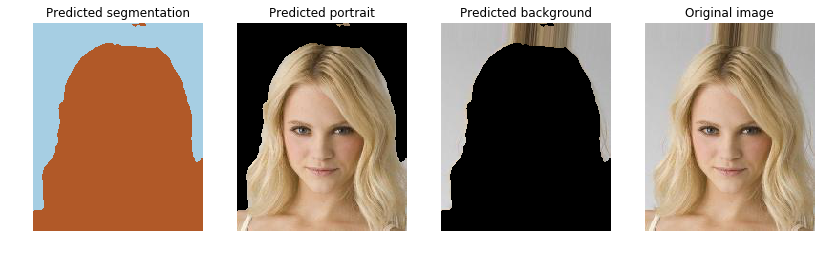

In [50]:
for num in np.random.randint(low = 0, high = 202600, size = 50):
    num = str(num)
    l = len(num)
    show_celeba_results('0'*(6-l) + num)

Also for the CelebA dataset, we see once more that our model seems to work fine when the background is clearly distinct from the face, while it has more problems when the distinction is not very clear. Hair details are not always prefectly captured, but qualitatively the result seems good. An additional source of confusion may have come from the low quality of the CelebA dataset pictures, but it seems like the model is not very sensitive to this.

We therefore conclude that our automatic portrait segmentation model is quite good and robust, as long as images do not contain too many fine details and there is some contrast between foreground and background.

***

# Conclusions

In this exercise we used the fastai library to develop an automatic portrait segmentation model and we applied it to the CelebA dataset.

Given that the CelebA dataset does not provide us ground truth segmentations, we used a different [portrait segmentation dataset](http://xiaoyongshen.me/webpages/webpage_automatting/) to train a U-Net for this segmentation task. Our model reaches an Intersection-over-Union (IoU) accuracy of 97.6% on the validation set of the portrait segmentation dataset (and 98.6% on the training set), a bit higher than what found in the literature we consulted. Quantitative statements about the IoU on the CelebA dataset cannot be provided, so we just resorted to examine our predictions by hand on a random subset of images. The qualitative results seem quite good, especially when background and foreground can be clearly distinguished and hair details are not too complicated.

Better results may be obtained with models more elaborated than a U-Net, or by a model which can predict not the segmentation but the more fine-grained alpha matte: we refer to the papers [Deep Automatic Portrait Matting](http://xiaoyongshen.me/papers/deepmatting.pdf) and [Semantic Human Matting](https://arxiv.org/pdf/1809.01354.pdf) for examples in this direction.